# Data Exploration

## Initialize Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from varclushi import VarClusHi

In [2]:
# plot defaults
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Target Variable Analysis

Our target variable is the expected loss per policy normalized by exposure: Expected Loss = Claim Cost (claimcst0) / Exposure

In [4]:
model_data = pd.read_csv('../backend/model_data.csv')
inference_data = pd.read_csv('../backend/inference_data.csv')

In [5]:
model_data['expected_loss'] = model_data['claimcst0'] / model_data['exposure']

## Visualize Frequency & Severity of Claims

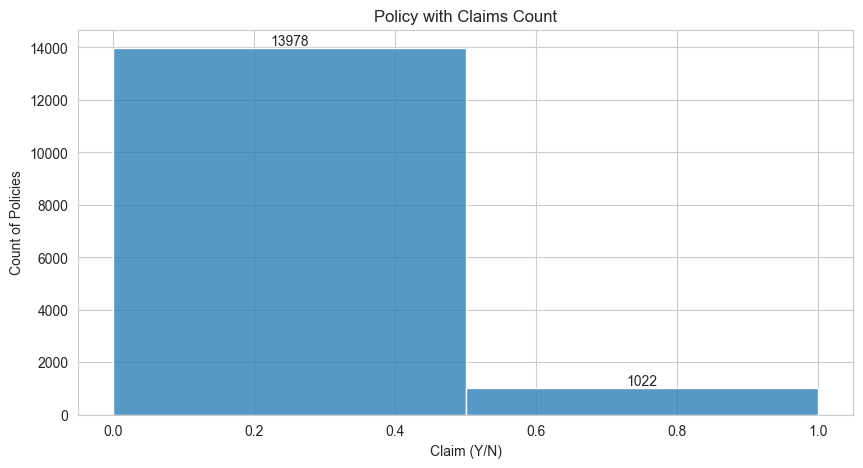

Base Claim Rate (Frequency): 6.81%


In [9]:
# Histogram of claim cost
plt.figure(figsize=(10, 6))
ax = sns.histplot(model_data['clm'], bins=2, kde=False)
for p in ax.patches:
    height = p.get_height()
    if height > 0: # Only annotate non-empty bins
        ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.1, # Adjust vertical position
            f'{int(height)}', # Format the count as an integer
            ha='center', va='bottom', fontsize=10)
plt.title('Policy with Claims Count')
plt.xlabel('Claim (Y/N)')
plt.ylabel('Count of Policies')
plt.show()

claim_rate = model_data['clm'].mean()
print(f"Base Claim Rate (Frequency): {claim_rate:.2%}")


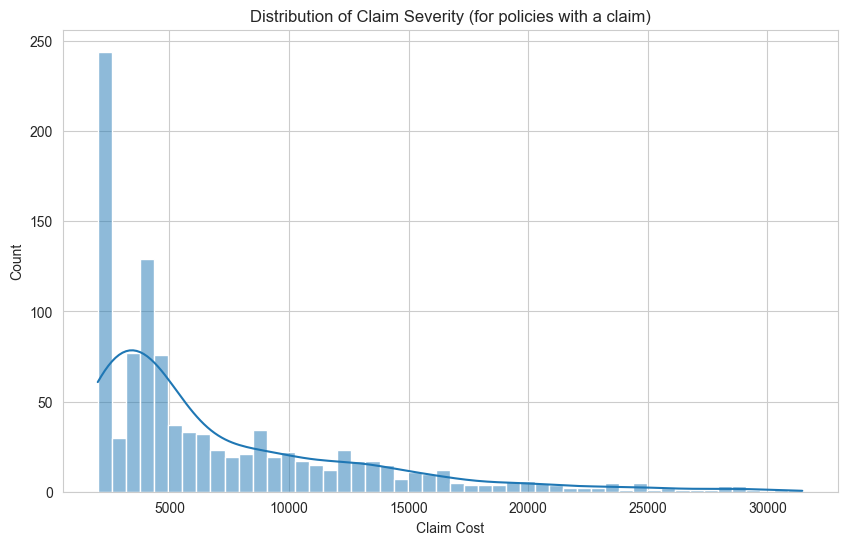

Average Claim Severity (cost when clm=1): $7,000.19


In [10]:
# Analyze severity (cost given a claim happened)
severity_df = model_data[model_data['clm'] == 1]

plt.figure(figsize=(10, 6))
sns.histplot(severity_df['claimcst0'], bins=50, kde=True)
plt.title('Distribution of Claim Severity (for policies with a claim)')
plt.xlabel('Claim Cost')
plt.show()

print(f"Average Claim Severity (cost when clm=1): ${severity_df['claimcst0'].mean():,.2f}")

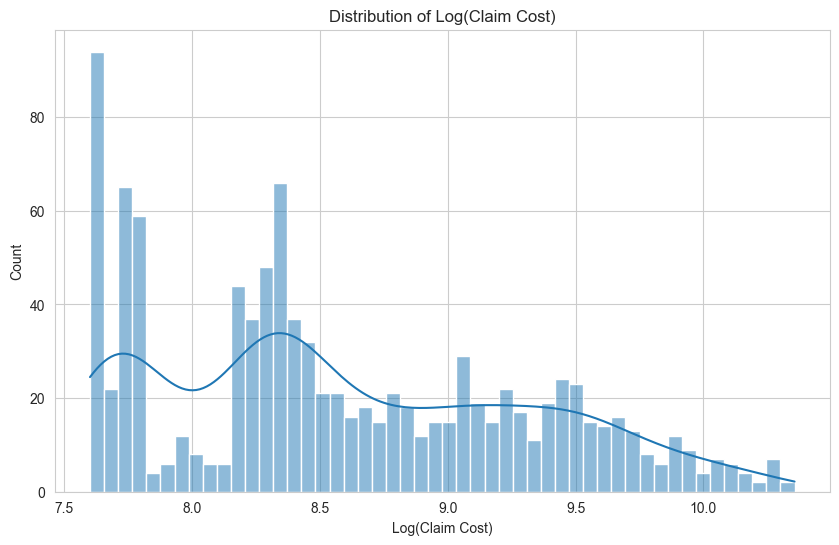

In [18]:
# Log-transform for a clearer view
plt.figure(figsize=(10, 6))
sns.histplot(np.log(severity_df['claimcst0']), bins=50, kde=True)
plt.title('Distribution of Log(Claim Cost)')
plt.xlabel('Log(Claim Cost)')
plt.show()

## Visualizing Predictors

In [22]:
# Identifying feature by type (numerical vs categorical)
num_features = [
    'exposure',
    'veh_value',
    'max_power',
    'driving_history_score',
    'credit_score'
]

cat_features = [
    'veh_age',
    'area',
    'veh_body',
    'gender',
    'agecat',
    'engine_type',
    'veh_color',
    'marital_status',
    'e_bill',
    'time_of_week_driven',
    'time_driven',
    'trm_len',
    'low_education_ind'
]

possible_target_features = [
    'clm',
    'numclaims',
    'claimcst0',
    'expected_loss'
]

# Make sure columns exist (no typos), redefine feature lists if a column not found
features = [col for col in num_features + cat_features + possible_target_features if col in model_data.columns]
num_features = [col for col in num_features if col in model_data.columns]
cat_features = [col for col in cat_features if col in model_data.columns]
possible_target_features = [col for col in possible_target_features if col in model_data.columns]

print(f"Found {len(features)} total features: {features}")

Found 22 total features: ['exposure', 'veh_value', 'max_power', 'driving_history_score', 'credit_score', 'veh_age', 'area', 'veh_body', 'gender', 'agecat', 'engine_type', 'veh_color', 'marital_status', 'e_bill', 'time_of_week_driven', 'time_driven', 'trm_len', 'low_education_ind', 'clm', 'numclaims', 'claimcst0', 'expected_loss']


           exposure     veh_value     max_power  driving_history_score  \
count  15000.000000  15000.000000  15000.000000           15000.000000   
mean       0.433825      5.525641    152.624733              86.099467   
std        0.274367      1.396837     54.266168              19.150395   
min        0.003238    -16.940000     60.000000              55.000000   
25%        0.201233      4.990000    113.000000              72.000000   
50%        0.385222      5.920000    144.000000              85.000000   
75%        0.648066      6.380000    181.000000              98.000000   
max        0.999378      7.570000    409.000000             153.000000   

       credit_score  
count  15000.000000  
mean     651.079795  
std       10.650815  
min      607.797435  
25%      643.770338  
50%      648.812543  
75%      655.798480  
max      747.001026  


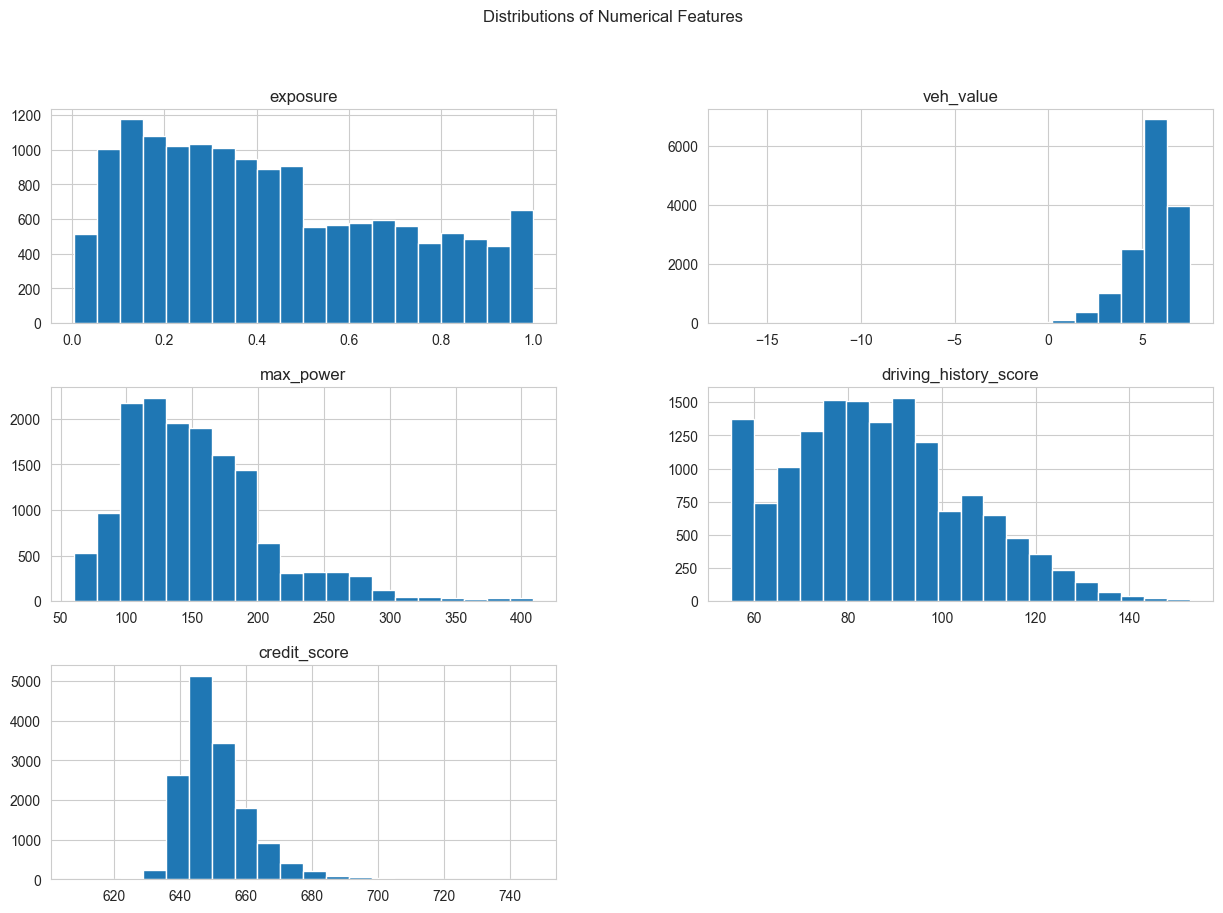

In [24]:
# Numerical features
if num_features:
    print(model_data[num_features].describe())
    model_data[num_features].hist(bins=20, figsize=(15, 10))
    plt.suptitle("Distributions of Numerical Features")
    plt.show()

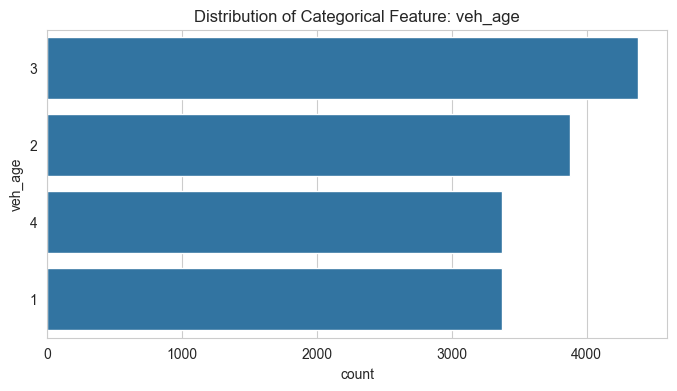

Value counts for veh_age:
veh_age
3    0.291867
2    0.258600
4    0.224800
1    0.224733
Name: proportion, dtype: float64



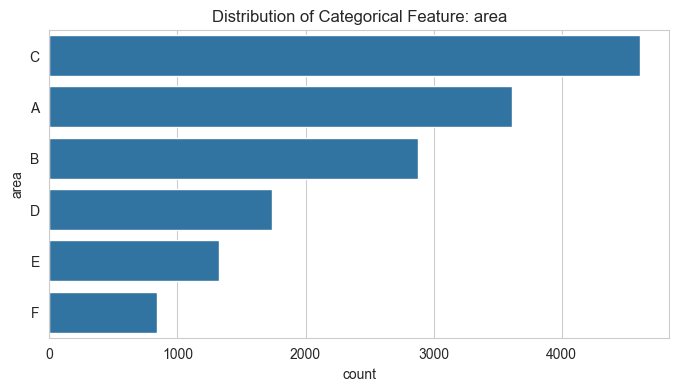

Value counts for area:
area
C    0.307400
A    0.240800
B    0.191800
D    0.115867
E    0.088067
F    0.056067
Name: proportion, dtype: float64



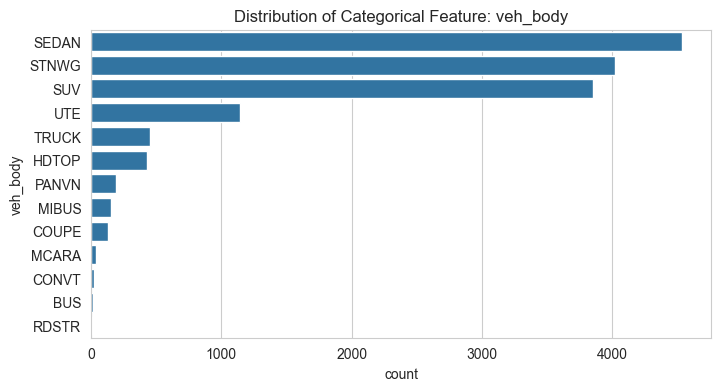

Value counts for veh_body:
veh_body
SEDAN    0.302200
STNWG    0.268333
SUV      0.257067
UTE      0.076267
TRUCK    0.030067
HDTOP    0.028467
PANVN    0.012867
MIBUS    0.010200
COUPE    0.008867
MCARA    0.002333
CONVT    0.001667
BUS      0.001133
RDSTR    0.000533
Name: proportion, dtype: float64



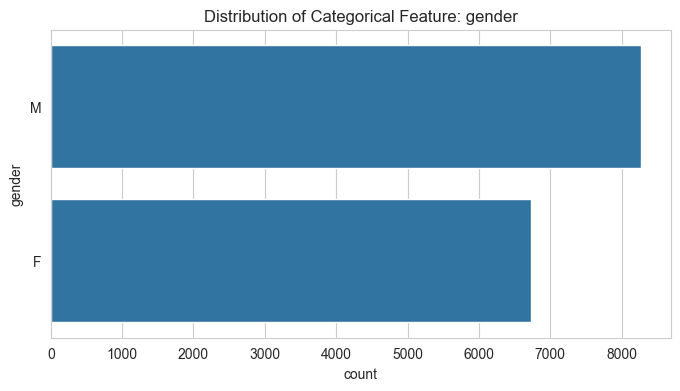

Value counts for gender:
gender
M    0.551667
F    0.448333
Name: proportion, dtype: float64



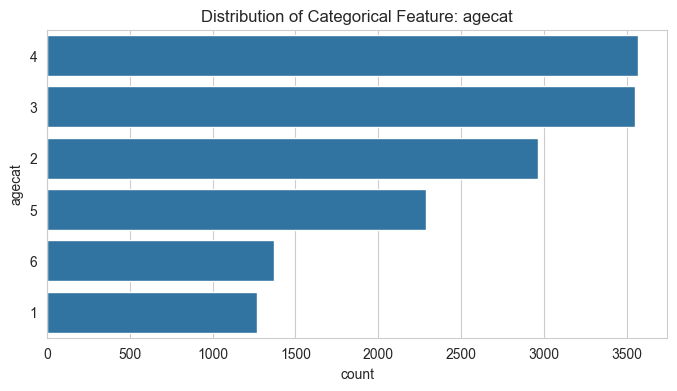

Value counts for agecat:
agecat
4    0.237667
3    0.236467
2    0.197533
5    0.152533
6    0.091200
1    0.084600
Name: proportion, dtype: float64



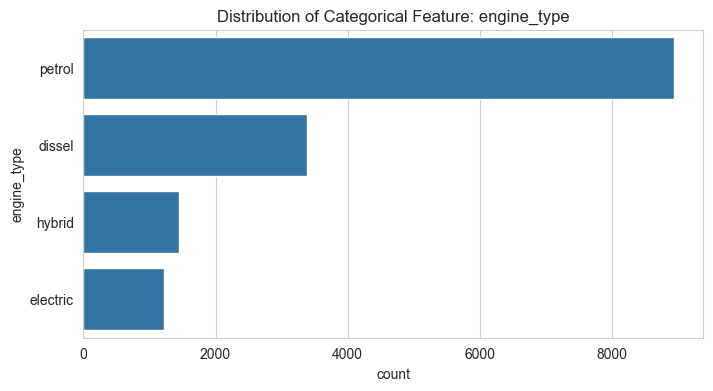

Value counts for engine_type:
engine_type
petrol      0.596067
dissel      0.226000
hybrid      0.096467
electric    0.081467
Name: proportion, dtype: float64



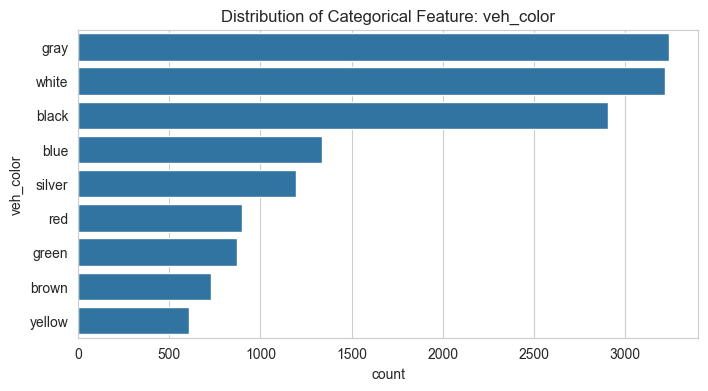

Value counts for veh_color:
veh_color
gray      0.215933
white     0.214600
black     0.193733
blue      0.089133
silver    0.079600
red       0.059733
green     0.058200
brown     0.048400
yellow    0.040667
Name: proportion, dtype: float64



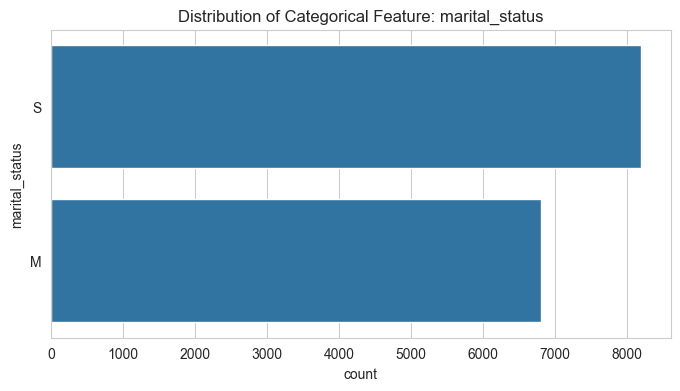

Value counts for marital_status:
marital_status
S    0.5464
M    0.4536
Name: proportion, dtype: float64



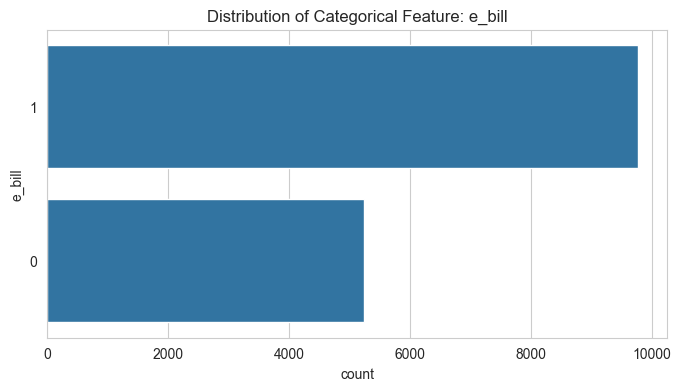

Value counts for e_bill:
e_bill
1    0.650533
0    0.349467
Name: proportion, dtype: float64



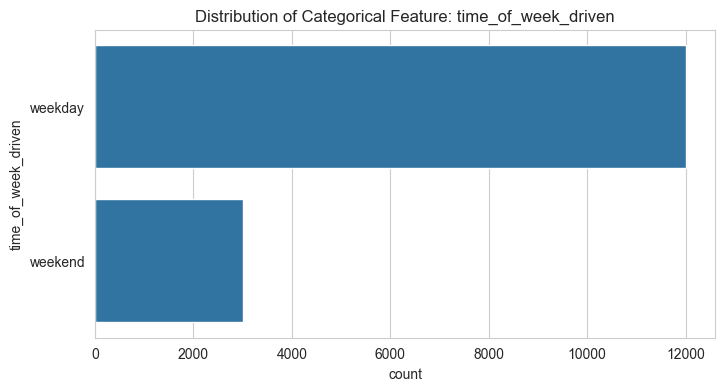

Value counts for time_of_week_driven:
time_of_week_driven
weekday    0.799867
weekend    0.200133
Name: proportion, dtype: float64



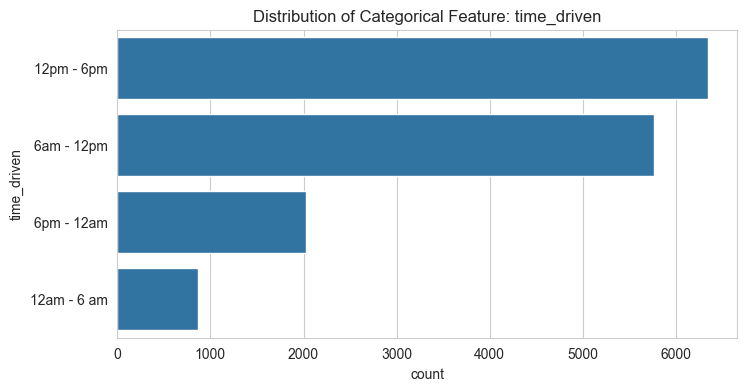

Value counts for time_driven:
time_driven
12pm - 6pm     0.422733
6am - 12pm     0.384067
6pm - 12am     0.135267
12am - 6 am    0.057933
Name: proportion, dtype: float64



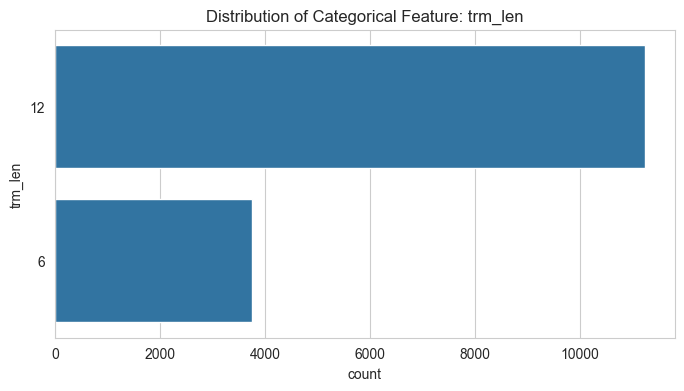

Value counts for trm_len:
trm_len
12    0.750067
6     0.249933
Name: proportion, dtype: float64



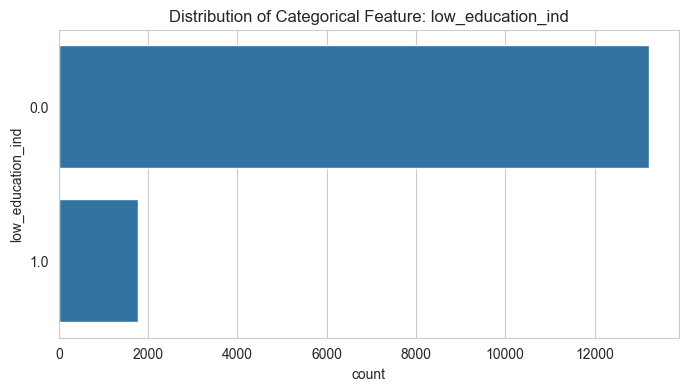

Value counts for low_education_ind:
low_education_ind
0.0    0.8816
1.0    0.1184
Name: proportion, dtype: float64



In [25]:
# Categorical features
if cat_features:
    for col in cat_features:
        plt.figure(figsize=(8, 4))
        sns.countplot(y=model_data[col], order=model_data[col].value_counts().index)
        plt.title(f"Distribution of Categorical Feature: {col}")
        plt.show()
        print(f"Value counts for {col}:\n{model_data[col].value_counts(normalize=True)}\n")

In [ ]:
possible_predictors = [
    'driving_history_score',
    'credit_score',
    'low_education_ind',
    'marital_status',
    'time_driven', # probably more important than day of week
    'area',
    'agecat',  #(encoded- young, middle, elder)
    'gender',
    'veh_color',
    'max_power',
    'engine_type',
    'veh_age',
    'veh_body', # encode- coupe, sedan, stnwg, suv, truck, ute, other)
    'veh_value',
]

## Target Encoding

## Check Variable Collinearity and Relationships

## Save Altered Data

In [11]:
model_data.to_csv('../project/model_data.csv', index=False)
inference_data.to_csv('../project/inference_data.csv', index=False)